## Use the pre-trained model to pick the arrivals

In [11]:
# Import python library
from keras.models import load_model
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.signal import butter, lfilter, lfilter_zi
import tensorflow as tf
import os
import sys
import random
sys.path.insert(1, '../')
from demos.utils import *

# set random seed
seed = 202404
np.random.seed(seed)
tf.random.set_seed(seed)

# Check GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)


# Make a new dir to save the picking error
directory_path = "../test_picking_results/"

# Create the directory, including any necessary parent directories
os.makedirs(directory_path, exist_ok=True)

2 Physical GPUs, 1 Logical GPU


## Define data path

In [2]:
signal_id_path = '../data/signalid_random_1.5w.npy'
TXED_path = os.getenv('HOME')+'/Yang/Data/Earthquake_data/TXED/TXED_0913.h5' # Here, you may need to change the path of TXED
Pwave_model_path = '../model/P_wave_phase_picking_best_model.h5'
Swave_model_path = '../model/S_wave_phase_picking_best_model.h5'
fig_path = '../figs/'

## Obtain the P- and S-wave arrivals from TXED

In [3]:
# load IDs and TXED
event_id = np.load(signal_id_path, 'r')
f_txed = h5py.File(TXED_path, 'r')

# obtain the P- and S-wave arrivals
P_arrival_list = []
S_arrival_list = []
print('-----------arrival time calculation begin-------------------')
for key in event_id:
    if key in f_txed:   
        dataset = f_txed.get(key)
        P_arrival_list.append(int(dataset.attrs['p_arrival_sample']))
        S_arrival_list.append(int(dataset.attrs['s_arrival_sample']))
P_arrival_list = np.array(P_arrival_list)
S_arrival_list = np.array(S_arrival_list)
P_phase_label = P_arrival_list
S_phase_label = S_arrival_list

print('-----------arrival time calculation end-------------------')
print(P_arrival_list.shape, P_arrival_list)
print(S_arrival_list.shape, S_arrival_list)

-----------arrival time calculation begin-------------------
-----------arrival time calculation end-------------------
(15000,) [ 99 498  98 ... 898 598 598]
(15000,) [ 616  709  382 ... 2003 2551 1035]


## Band-pass and normalization of the 3-C waveforms

In [4]:
signal_list = []
print('-----------signal format convert begin-------------------')
for key in event_id:
    if key in f_txed:   
        dataset = f_txed.get(key)
        datas = dataset['data']
        datas = np.array(datas)
        datas_0 = butter_bandpass_filter_zi(datas[:,0], 1, 45, 100, order=3)
        datas_1 = butter_bandpass_filter_zi(datas[:,1], 1, 45, 100, order=3)
        datas_2 = butter_bandpass_filter_zi(datas[:,2], 1, 45, 100, order=3)
        datas = np.vstack([datas_0, datas_1, datas_2])
        signal_list.append(datas) 
signal_values = np.array(signal_list)
bp_signal= np.transpose(signal_values, [0, 2, 1])


#Normalized trace-by-trace
max_values_per_event = np.max(bp_signal, axis=1)
# Normalize each component of each event by dividing by its maximum value
normalized_phase_data = bp_signal / max_values_per_event[:, np.newaxis, :]
print('-----------signal format convert finihs-------------------')
print(bp_signal.shape)

-----------signal format convert begin-------------------
-----------signal format convert finihs-------------------
(15000, 6000, 3)


## Model inference

In [5]:
## Load the pre-trained model and perform the inference
learning_rate = 0.001  # Specify your learning rate

P_phase_model = load_model(f'{Pwave_model_path}')
S_phase_model = load_model(f'{Swave_model_path}')

P_phase_output = P_phase_model.predict(normalized_phase_data)
S_phase_output = S_phase_model.predict(normalized_phase_data)

## Calculating and saving the predicted error of the proposed model
Proposed_P_error_indx = evaluate_picking(P_phase_output, P_phase_label)
Proposed_S_error_indx = evaluate_picking(S_phase_output, S_phase_label)

## Saving the results
np.save('../test_picking_results/Pwave_error.npy', Proposed_P_error_indx)
np.save('../test_picking_results/Swave_error.npy', Proposed_S_error_indx)

2024-11-16 10:37:54.841766: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


469/469 [==============================] - 8s 14ms/step


## Evaluate picking results

In [6]:
xx = 2 # the threshold to filter outliers
P_error_proposed, mae_P_proposed, std_P_proposed, precision_P_proposed = cal_mae_std(Proposed_P_error_indx, xx)
S_error_proposed, mae_S_proposed, std_S_proposed, precision_S_proposed = cal_mae_std(Proposed_S_error_indx, xx)


random.seed(202411)
P_indices = [i for i, x in enumerate(Proposed_P_error_indx) if x<2]
S_indices = [i for i, x in enumerate(Proposed_S_error_indx) if x<2]
P_selected_index = random.sample(P_indices, 10)
S_selected_index = random.sample(S_indices, 10)

print(f'P-wave MAE and sigma of proposed: {mae_P_proposed:.4f} s\t{std_P_proposed:.4f} s')
print(f'S-wave MAE and sigma of proposed: {mae_S_proposed:.4f} s\t{std_S_proposed:.4f} s')
print(f'P-wave precision of proposed: {precision_P_proposed:.2f} %\tS-wave precision of proposed: {precision_S_proposed:.2f} %')

P-wave MAE and sigma of proposed: 0.1310 s	0.3090 s
S-wave MAE and sigma of proposed: 0.1691 s	0.3278 s
P-wave precision of proposed: 97.05 %	S-wave precision of proposed: 96.97 %


## Plot histogram of error distributions

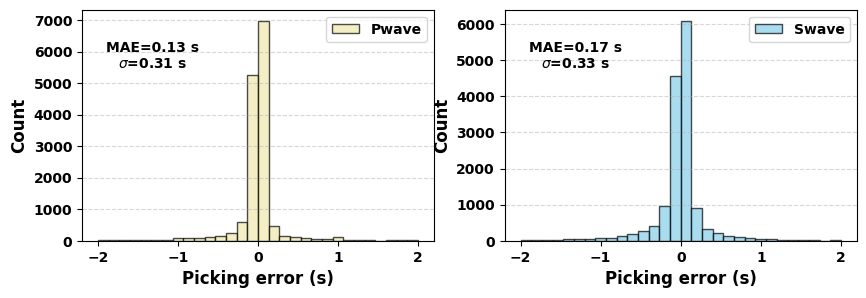

In [14]:
plt.figure(figsize=(10, 3))  # Set figure size
ax = plt.subplot(121)
plt.hist(P_error_proposed, bins=30, color='palegoldenrod', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_P_proposed:.2f} s\n$\sigma$={std_P_proposed:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Pwave'], prop={'weight': 'bold'})

ax = plt.subplot(122)
plt.hist(S_error_proposed, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_S_proposed:.2f} s\n$\sigma$={std_S_proposed:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Swave'], prop={'weight': 'bold'})